# Dataset

In this homework, we'll build a model for predicting if we have an image of a dino or a dragon. For this, we will use the "Dino or Dragon?" dataset that can be downloaded from Kaggle.

You can get a wget-able version here:

In [1]:
#!wget https://github.com/alexeygrigorev/dino-or-dragon/releases/download/data/dino-dragon.zip
#!unzip dino-dragon.zip

In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch.

**Note:** You will need an environment with a GPU for this homework. We recommend to use [Saturn Cloud](https://bit.ly/saturn-mlzoomcamp). 
You can also use a computer without a GPU (e.g. your laptop), but it will be slower.

Data Preparation
The dataset contains around 1900 images of dinos and around 1900 images of dragons.

The dataset contains separate folders for training and test sets.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.preprocessing import load_img
from keras_preprocessing.image import load_img
from keras_preprocessing.image import ImageDataGenerator

import time
from PIL import Image

%matplotlib inline

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

2022-11-20 10:14:41.990297: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
tf.__version__

'2.9.1'

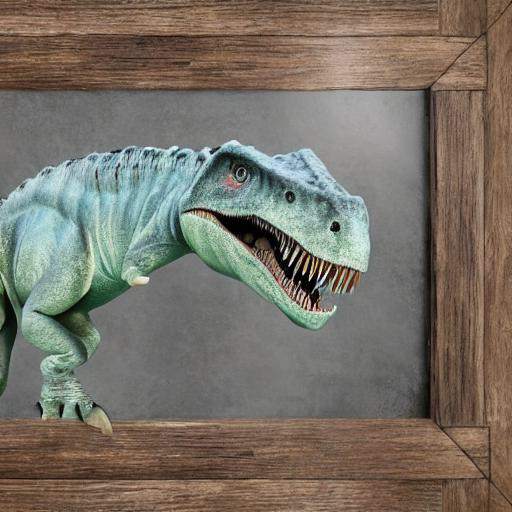

In [4]:
# Load an image for testing
path = './train/dino'
name = '03958547-38fc-4635-abfb-3bc6b3a1e540.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

### Model

For this homework we will use Convolutional Neural Network (CNN). Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a convolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`

For clarification about kernel size and max pooling, check [Office Hours](https://www.youtube.com/watch?v=1WRgdBTUaAc).

In [5]:
inputs = keras.Input(shape=(150, 150, 3))

conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),
                           activation="relu")(inputs)

max_pool_2d = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)

vectors = keras.layers.Flatten()(max_pool_2d)

dense = keras.layers.Dense(64, activation='relu')(vectors)

outputs = keras.layers.Dense(1, activation='sigmoid')(dense)

model = keras.Model(inputs, outputs)

optimizer = keras.optimizers.SGD(learning_rate=0.002, momentum=0.8)

2022-11-20 10:14:43.521223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 10:14:43.528325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 10:14:43.528990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 10:14:43.529885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

- **`binary crossentropy`**
- `focal loss`
- `mean squared error`
- `categorical crossentropy`

Note: since we specify an activation for the output layer, we don't need to set `from_logits=True`

In [6]:
loss = keras.losses.BinaryCrossentropy()

### Question 2

What's the total number of parameters of the model? You can use the `summary` method for that. 

- 9215873
- **11215873**
- 14215873
- 19215873

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

### Generators and Training

For the next two questions, use the following data generator for both train and test sets:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/val directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and test sets. 

For training use `.fit()` with the following params:

```python
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)
```

In [8]:
train_gen = ImageDataGenerator(rescale=1. / 255)
test_gen = ImageDataGenerator(rescale=1. / 255)

train_ds = train_gen.flow_from_directory('./train',
                                         class_mode='binary',
                                         target_size=(150, 150),
                                         batch_size=20,
                                         shuffle=True)

test_ds = test_gen.flow_from_directory('./test',
                                       class_mode='binary',
                                       target_size=(150, 150),
                                       batch_size=20,
                                       shuffle=True)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


In [9]:
train_ds.class_indices

{'dino': 0, 'dragon': 1}

In [10]:
test_ds.class_indices

{'dino': 0, 'dragon': 1}

In [11]:
# Add the optimizer, loss, and performance metric to the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10


2022-11-20 10:14:45.824338: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-20 10:14:46.444159: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-20 10:14:46.445245: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-20 10:14:46.445279: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-20 10:14:46.446177: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-20 10:14:46.446239: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


80/80 [==============================] - 11s 105ms/step - loss: 0.6584 - accuracy: 0.6223 - val_loss: 0.5703 - val_accuracy: 0.7843
Epoch 2/10
80/80 [==============================] - 8s 103ms/step - loss: 0.5282 - accuracy: 0.7553 - val_loss: 0.4792 - val_accuracy: 0.8198
Epoch 3/10
80/80 [==============================] - 8s 103ms/step - loss: 0.4553 - accuracy: 0.7892 - val_loss: 0.4370 - val_accuracy: 0.8020
Epoch 4/10
80/80 [==============================] - 8s 103ms/step - loss: 0.4051 - accuracy: 0.8300 - val_loss: 0.4286 - val_accuracy: 0.7868
Epoch 5/10
80/80 [==============================] - 8s 102ms/step - loss: 0.3395 - accuracy: 0.8614 - val_loss: 0.3741 - val_accuracy: 0.8299
Epoch 6/10
80/80 [==============================] - 8s 103ms/step - loss: 0.3159 - accuracy: 0.8701 - val_loss: 0.3263 - val_accuracy: 0.8655
Epoch 7/10
80/80 [==============================] - 8s 102ms/step - loss: 0.2955 - accuracy: 0.8802 - val_loss: 0.3056 - val_accuracy: 0.8706
Epoch 8/10
80/80

In [13]:
path = './test/dino/03b62646-cdd1-4988-b3ca-d13afd91e34b.jpg'
#name = '0967e534-cc4b-4e91-a995-3d2407bcf08a.jpg'
#fullname = f'{path}/{name}'
# load_img(fullname)

In [14]:
img = load_img(path, target_size=(150, 150))

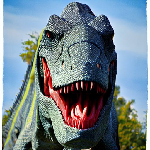

In [15]:
img

In [16]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 150, 150, 3)

In [17]:
pred = model.predict(X)

1/1 [==============================] - 0s 90ms/step


In [18]:
pred[0]

array([0.], dtype=float32)

In [19]:
classes = ['dino', 'dragon']

In [20]:
dict(zip(classes, pred[0]))

{'dino': 0.0}

### Question 3

What is the median of training accuracy for all the epochs for this model?

- 0.40
- 0.60
- **0.90**
- 0.20

In [21]:
training_accuracy = pd.DataFrame(history.history["accuracy"])

In [22]:
training_accuracy.sort_values

<bound method DataFrame.sort_values of           0
0  0.622334
1  0.755332
2  0.789210
3  0.829987
4  0.861355
5  0.870138
6  0.880176
7  0.911543
8  0.916562
9  0.927227>

In [23]:
training_accuracy.median().round(2)

0    0.87
dtype: float64

### Question 4

What is the standard deviation of training loss for all the epochs for this model?

- **0.11**
- 0.66
- 0.99
- 0.33

In [24]:
training_loss = pd.DataFrame(history.history["loss"])

In [25]:
training_loss.std().round(2)

0    0.14
dtype: float64

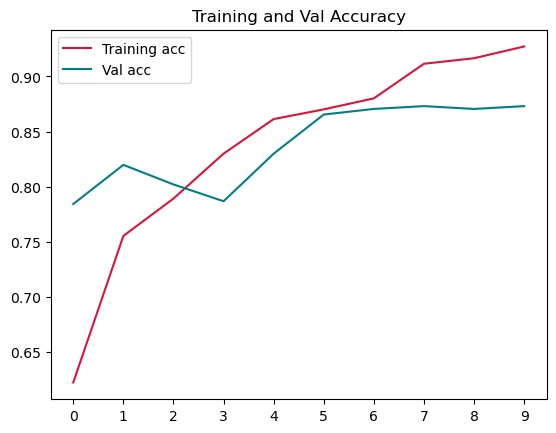

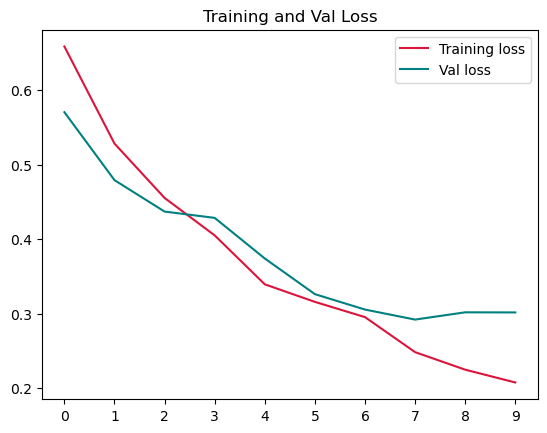

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, 'crimson', label='Training acc')
plt.plot(val_acc, 'teal', label='Val acc')
plt.title('Training and Val Accuracy')
plt.xticks(np.arange(10))
plt.legend()

plt.figure()

plt.plot(loss, 'crimson', label='Training loss')
plt.plot(val_loss, 'teal', label='Val loss')
plt.title('Training and Val Loss')
plt.xticks(np.arange(10))
plt.legend()

plt.show()

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=40,`
* `width_shift_range=0.2,`
* `height_shift_range=0.2,`
* `shear_range=0.2,`
* `zoom_range=0.2,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

In [27]:
train_gen_aug = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


### Question 5 

Let's train our model for 10 more epochs using the same code as previously.
Make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

- 0.15
- 0.77
- **0.37**
- 0.97

In [28]:
train_ds_aug = train_gen_aug.flow_from_directory('./train',
                                                 class_mode='binary',
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 shuffle=True)

test_ds_aug = test_gen.flow_from_directory('./test',
                                           class_mode='binary',
                                           target_size=(150, 150),
                                           batch_size=20,
                                           shuffle=True)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


In [29]:
history2 = model.fit(train_ds_aug, epochs=10, validation_data=test_ds_aug)

Epoch 1/10
80/80 [==============================] - 15s 188ms/step - loss: 0.4455 - accuracy: 0.7980 - val_loss: 0.3992 - val_accuracy: 0.8147
Epoch 2/10
80/80 [==============================] - 15s 185ms/step - loss: 0.4256 - accuracy: 0.8074 - val_loss: 0.3686 - val_accuracy: 0.8299
Epoch 3/10
80/80 [==============================] - 15s 185ms/step - loss: 0.4076 - accuracy: 0.8156 - val_loss: 0.4325 - val_accuracy: 0.8020
Epoch 4/10
80/80 [==============================] - 15s 184ms/step - loss: 0.3826 - accuracy: 0.8237 - val_loss: 0.6406 - val_accuracy: 0.7513
Epoch 5/10
80/80 [==============================] - 15s 185ms/step - loss: 0.4347 - accuracy: 0.8074 - val_loss: 0.6516 - val_accuracy: 0.7259
Epoch 6/10
80/80 [==============================] - 15s 183ms/step - loss: 0.3826 - accuracy: 0.8319 - val_loss: 0.4770 - val_accuracy: 0.7919
Epoch 7/10
80/80 [==============================] - 15s 184ms/step - loss: 0.3721 - accuracy: 0.8388 - val_loss: 0.9224 - val_accuracy: 0.6497

In [30]:
validation_loss_aug = pd.DataFrame(history2.history["val_loss"])

In [31]:
validation_loss_aug.mean().round(2)

0    0.55
dtype: float64

### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

- **0.84**
- 0.54
- 0.44
- 0.24

In [32]:
validation_acc_aug = pd.DataFrame(history2.history["val_accuracy"])

In [33]:
validation_acc_aug

,0
0,0.814721
1,0.829949
2,0.802030
3,0.751269
4,0.725888
5,0.791878
6,0.649746
7,0.802030
8,0.779188
9,0.748731


In [34]:
validation_acc_aug[5:].mean()

0    0.754315
dtype: float64

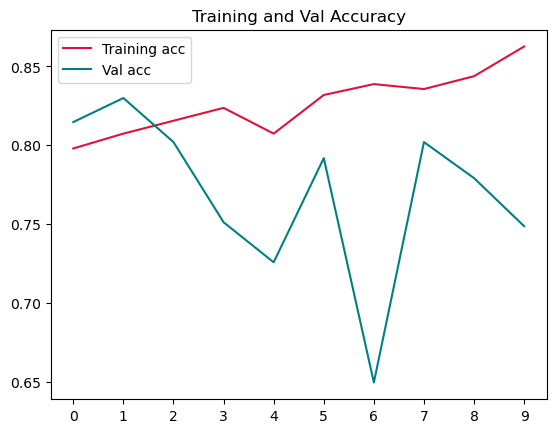

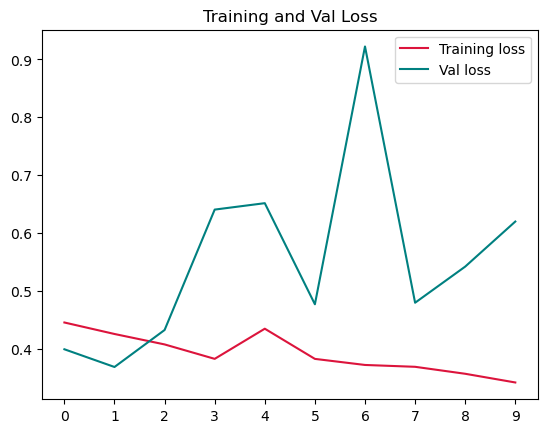

In [35]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.plot(acc, 'crimson', label='Training acc')
plt.plot(val_acc, 'teal', label='Val acc')
plt.title('Training and Val Accuracy')
plt.xticks(np.arange(10))
plt.legend()

plt.figure()

plt.plot(loss, 'crimson', label='Training loss')
plt.plot(val_loss, 'teal', label='Val loss')
plt.title('Training and Val Loss')
plt.xticks(np.arange(10))
plt.legend()

plt.show()

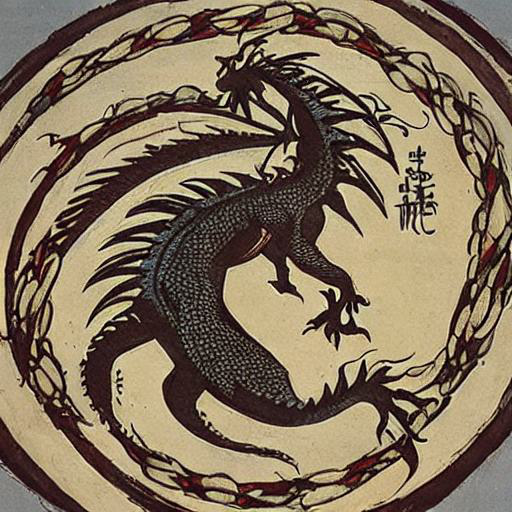

In [36]:
path = './test/dragon'
name = '0967e534-cc4b-4e91-a995-3d2407bcf08a.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [37]:
img = load_img(fullname, target_size=(150, 150))

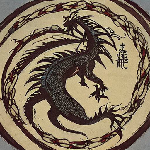

In [38]:
img

In [39]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 150, 150, 3)

In [40]:
pred = model.predict(X)

1/1 [==============================] - 0s 15ms/step


In [41]:
pred

array([[1.]], dtype=float32)

In [42]:
classes = ['dino', 'dragon']

In [43]:
dict(zip(classes, pred[0]))

{'dino': 1.0}